<br>

#### 1. Cython 활용 방법

- 원글 @ https://goo.gl/BjJKqG & https://goo.gl/wniKBf
- Jupyter notebook 외부에서 Cython 사용 희망 시 @ https://goo.gl/WZAFAZ

#### 추가 참고자료
- Can Cython make Python Great in Programming Contests? @ https://goo.gl/7qUUm8
- Cython official website @ https://goo.gl/nvSB86
- Cython basic tutorial @ https://goo.gl/po9T1B
- Cython Language Basics @ https://goo.gl/9Q8LNY
- PyPy, Cython, CTypes 속도 비교 @ https://goo.gl/wezF8r

following images @ https://goo.gl/cVO6Qr

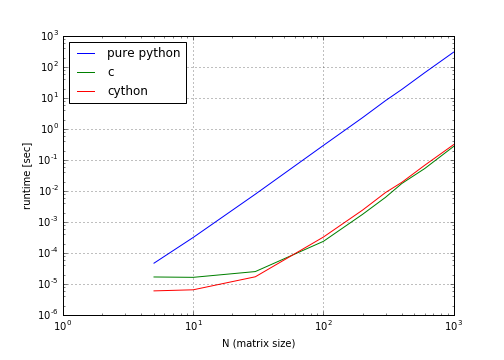

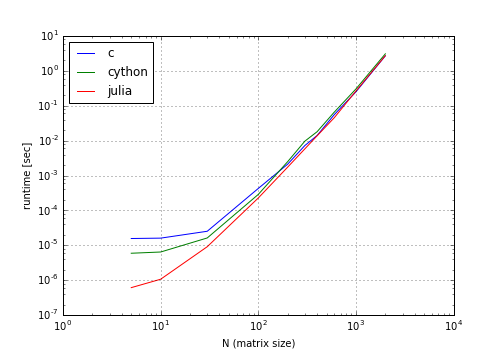

15. Cython을 통해서 성능 향상시키기 

cython을 사용하는 방법은 간단한 것에서부터 어려운 단계까지 다양하다. 다음과 같은 레벨로 진행된다.

>**1. 그냥 컴파일만 해서 20% 성능 향상을 이룬다.
<br>2. 각 variable의 type을 하나씩 지정해주어서 3~40배 가량의 성능 향상을 이룬다.
<br>3. array를 좀더 정밀하게 다루어서 40~50배 가량의 성능 향상을 이룬다.
<br>4. numpy와 조합하여 50~100배가량의 성능 향상을 이룬다.**

번외편으로,
<br>**pypy를 사용하여 20배의 성능향상을 이룬다.
<br>numba을 사용하여 20배~100배의 성능 향상을 이룬다.(numba는 string에는 효과가 없다.)
<br>다른 언어(c, julia, java...) 를 파이썬으로 감싼다.**

cython을 사용하려면 compile을 해야하고 코드가 길어지면 compile 속도가 느려지는 단점이 있다. 또한 디버깅이 어려워진다. 
<br>거기에 새롭고 어려운 문법체계를 하나 더 배워야 한다는 부담감이 있다. 
<br>그러나 일단 한번 제대로 만들어 두면 속도 향상에 큰 도움이 된다. 
<br>cython은 module로 호출하여 사용되게끔 만들어져 있는 이유도 이 때문이다. 
<br>모든 부분을 cython화 하기에는 시간과 노력이 많이 든다. 
<br>따라서 profiling을 하여 성능향상이 꼭 필요한 부분에만 cython을 적용하고 나머지는 python이나 c로 작성된 library를 사용하는 것이 좋다.

일단, **cython을 사용하려면 compile을 하거나 jupyter를 사용하여 %load_ext Cython 치고 엔터, 
<br>%%cython 치고 엔터 후에 cython code를 작성하면 된다.**

예를 들면, 피보나치수열은 다음과 같이 작성하여 성능을 테스트 할 수 있다.

In [1]:
%load_ext Cython

In [9]:
%%cython

cpdef fib(int n): # 원글의 cdef 는 에러 발생, cpdef 로 수정 필요
    cdef int a, b, i
    a, b = 1, 1
    for i in range(n):
        a, b = a+b, a
    return a

In [11]:
%timeit fib(1000)

757 ns ± 22.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [12]:
def fib_pure(n):
    a, b = 1, 1
    for i in range(n):
        a, b = a+b, a
    return a

In [13]:
%timeit fib_pure(1000)

143 µs ± 2.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**143 us = 143 * 1000 ns = 143000 ns
<br> 143000 ns /757 ns = 189배 느림**

똑같은 fib() function이지만 cython으로 작성한 cdef fib()의 경우 565ns가 나왔고 pure python의 경우에는 87us가 나왔다. 
<br>앞의 nano second는 1000ns = 1 us이다. 즉 100배 이상 빠르다는 것을 알 수 있다. 
<br>물론 이것은 단순 연산에 해당하는 내용이며, 단지 단순 연산을 pure python으로 구동하는데에 성능 상 큰 문제가 있다면 cython이 좋은 대안이 될 수 있다.

jupyter 환경을 사용할 수 없다면, 이전 포스트에 cython compiling하는 방법을 적어놓았다. 이를 참고하면 된다.
http://blog.naver.com/ossiriand/220287019598

pandas의 dataframe은 cython에 직접적으로 활용할 수는 없고 df['a']식으로 series를 호출한다음 df['a'].value를 사용하여 numpy array로 변환한 후에 function에 입력하게 된다. 즉, numpy array만 cython으로 성능을 향상시킬 수 있다. 


numpy array를 cython에서 type 선언하는 방법은 
> cimport numpy as np
<br>import numpy as np
<br>cdef np.ndarray Array_name

위와 같은 방식을 따른다.

In [8]:
%%cython

# cython: boundscheck=False
# cython: wraparound=False

import pandas as pd
cimport numpy as np
import numpy as np

cpdef np.ndarray fib(np.ndarray arFib): # 첫번째 np.ndarray : return의 타입
    cdef np.ndarray[double] result = np.empty(len(arFib)) # np.empty : Return a new array of given shape and type, without initializing entries.
    cdef int a, b, i, count
    a, b = 1, 1
    count = -1
    for i in arFib:
        count += 1
        for j in range(i):
            a, b = a+b, a
        result[count] = a
        a, b = 1, 1
    return result

df = pd.DataFrame([10, 100, 1000, 10000])
arFib = df[0].values
print(fib(arFib))

[ 1.44000000e+02  1.44526350e+09 -1.42044334e+09 -9.20388072e+08]


아직 cython 문법을 명확하게 파악하고 있는 편이 아니라서 작동하는 기준으로 작성하였다. 
<br>#으로 주석처리한 것은 사실 @(decorator)가 작동하지 않아서 다른 방법을 사용한 것이다. 저렇게 해도 데코레이터와 동일하게 동작한다. 

https://github.com/adrn/cython-tutorial/blob/master/1-notebook/1-notebook.ipynb
(위 사이트에서 해당 기능에 대한 주석이 있다.)

fib() function에 여러 입력값을 넣기 위해 numpy array를 사용한 방법이다. 
<br>cpdef 부분에는 return값이 있으면 return 값의 type을 적어준다. 이는 c언어와 동일한 방식이다. 
<br>내부의 for loop를 사용하여 결과값을 새로운 array에 저장해야하는데 그것이 np.ndarray[double] result = np.empty(len(arFib)) 이다. 
<br>이것을 파이썬 문법으로 보자면 result = [] 인데, cython의 경우는 result의 type을 적어줘야하고 []의 배열 크기를 지정해야한다. 
<br>물론 c언어와 유사한 문법체계로 []의 크기는 사실 arFib로 들어본 10, 100, 1000, 10000 이므로 4개인데, len으로 그것의 개수를 계산한 것이다. 
<br>또한 c언어에는 python처럼 append가 없으므로 저장될 위치를 하나씩 지정해서 넣어야한다. 
<br>배열의 첫번째에 fib(10)을 넣기 위해서는 result[0] = fib(10) 처럼 결과가 들어갈 자리를 지정해주는 구문이 필요하다. 
<br>그래서 위의 코드에 count를 넣어준 것이다. 

그리고 아래의 결과를 보았을 때 첫번째와 두번째의 경우 예상한 수가 나오지만 뒤에서 부터는 -로 나오는 것을 확인할 수 있다. 
<br>double 허용치의 max를 넘어서서 -값으로 나온 것으로 보이는데, 위에서는 약간 예상보다 작은 수임에도 -값으로 나와서 좀더 살펴봐야할 것 같다.

어쨌거나, e200을 넘어서는 수치 계산은 웬만해서는 거의 하지 않기 때문에 사용하는데에는 큰 문제가 없을 것 같다.

여기서 한 단계 더 나아가는 방법은 np.array의 내부 type까지 지정해주는 것이다. 
<br>하지만 노력 대비 성능을 비교해봤을때 아직은 굳이 거기까지 갈 필요가 없어서 이 내용은 필요할 때 다시 추가할 계획이다.

<br>

#### 2. loop 문 속도 향상시키기 
@ https://goo.gl/M2HzL1

In [13]:
def test1():
    a = []
    for i in range(1000000):
        a.append(i)
    
# 주의: 확실한 테스트 후에 사용하길 권장함. 어떤 경우 결과값이 사라져버리는 현상 발생.
def test2():
    a = []
    append = a.append # .을 loop 밖에서 미리 선언한 후에 실행한 구문이다. 약 30% 정도 향상이 있다.
    for i in range(1000000):
        append(i)
        
# 결론 : list comprehension 이 제일 빠르다.
def test3(): # 파이썬에서 가장 빠르다고 알려진 list comprehension이다. 가장 빠르다.
    a = [i for i in range(1000000)]

In [15]:
%timeit test1()

218 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit test2()

163 ms ± 7.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit test3()

118 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


인터넷을 검색하다가 어떤 할머니께서 포스팅한 내용을 참고하여 테스트를 해보았다.
<br>파이썬에서 .  을 쓰면 속도가 저하되는 현상이 있다. 
<br>이럴 때 간단하게 속도를 높여주는 방법은 loop 밖에 변수로 .이 들어간 구문을 미리 적어두는 것이다.

1번은 일반적으로 . 을 사용한 구문이다.
<br>3번은 .을 loop 밖에서 미리 선언한 후에 실행한 구문이다. 약 30% 정도 향상이 있다.
<br>5는 파이썬에서 가장 빠르다고 알려진 list comprehension이다. 1, 3 보다 더 빠르다.

list comp를 쓸 수 없을 때 성능을 약간 더 높이고 싶다면 loop 밖에 미리 선언하는 방법을 선택할 수 있다.

<br>

#### 3.numpy는 되도록 loop를 배제할 것 
@ https://goo.gl/GdMfPz

In [18]:
def test_np2(): # wins
    a = np.arange(10000000)
    b = a > 100000
    
def test_np(): # loses
    a = range(10000000)
    b = [i for i in a if i > 100000]

In [19]:
%timeit test_np2()

48.4 ms ± 6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%timeit test_np()

1.62 s ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


in29는 loop를 사용하지 않은 numpy 속도,
<br>in31은 loop를 사용한 pure python.
<br>대략 30배정도 빠르다. 

numpy의 경우에 loop를 쓰면 pure python과 속도가 비슷해진다.
<br>R처럼 loop를 최대한 배제한 코드를 만드는 게 numpy performance에 도움이 된다.

In [24]:
def test_np3(): # wins
    b = pd.DataFrame(np.arange(10000000))
    c = b > 100000
    
def test_np4(): # loses
    b = pd.DataFrame(list(range(10000000)))
    c = b > 100000

In [22]:
%timeit test_np3()

65.8 ms ± 5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%timeit test_np4()

5.1 s ± 337 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


in 47은 numpu array사용
<br>in 50은 pure python list 사용

pandas의 경우 Dataframe으로 변환시 
<br>pure python list를 쓰는 것보다 numpy array를 사용했을 때가 훨씬 더 빠르다.
<br>따라서 pandas dataframe을 만들 때 numpy array로 만들어 두면 좋을 듯하다.

<br>

#### 4. 멀티 코어 프로세싱 (미완성)
@ https://goo.gl/nTjLpF

서버로 프로그래밍을 하다보면 sun grid engine을 사용하여 코어가 4개 이상인 pc cluster를 활용하곤 한다. 20개의 노드에 코어가 24개씩 있으면 job을 480개로 분할해서 하나씩 일을 주는 것이다. 개인용 pc에서는 이런 방법이 통하지 않으니 python의 multiprocessing을 사용해야한다.

파이썬에서는 thread와 multiprocessing이라는 두 가지 내부 모듈이 있는데, 처음에는 이 둘이 어떤 이유로 성능차이를 보이는지 알 수 없었지만 관련 책자들을 찾아보다 보니 그 차이와 활용시점에 대해서 기술되어 있었다.

**thread는 CPU보다는 latency time이 있는 일에 효과적이고
<br>multiprocessing은 CPU 의존적인 작업에 활용하는 것에 효과적이다.**

따라서 thread를 4개를 쓴다고 해서 CPU 의존적인 작업의 처리에 속도향상이 나타나지 않는다. multiprocessing을 사용해야 다중 코어의 속도향상을 체험할 수 있다.

다중코어를 사용한다고 해서 속도가 선형적으로 증가하는 것은 아니다. 따라서 코어를 8개 동시에 쓰는 작업이 8배의 성능 향상을 가져오지는 못한다. 해당 코어의 효율을 대략적으로 나타낸 그래프는 다음과 같다.

In [17]:
import multiprocessing as mp
mp.freeze_support()

def work(job_list):
    return job_list + 1

p = mp.Pool(4)
p.map_async(work, job_list).get()

NameError: name 'job_list' is not defined

<br>

#### 5. 데이터 과학자라면 알고 넘어가야할 소수점 연산  
@ https://goo.gl/YEbDqm

#### 소수점 더하기

In [1]:
0.1 + 0.2

0.30000000000000004

In [31]:
import decimal 
float(decimal.Decimal('0.1') + decimal.Decimal('0.2'))

0.3

In [33]:
float(decimal.Decimal(0.1) + decimal.Decimal(0.2))

0.30000000000000004

**한가지 유의할 점은 입력란에 들어갈 인자는 str이어야한다는 것이다.**
<br>float로 집어넣을 경우 2번과 같이 의도하지 않은 결과가 나온다.

#### 소수점 곱하기 & log 적용하기

In [34]:
a = 2**(-340)
a*a*a*a

0.0

In [35]:
a = decimal.Decimal('4.464794497196386649280404486E-103')
a**10

Decimal('3.147855168679442488609869602E-1024')

In [36]:
import math
math.log10(a**10)

ValueError: math domain error

In [38]:
float(decimal.Decimal.log10(a**10))

-1023.501985257536